In [1]:
import numpy as np
import pandas as pd
from scipy.special import logit
from fairforest import d_tree
from fairforest import utils
import warnings
import matplotlib.pyplot as plt
from sklearn import tree

In [2]:
warnings.simplefilter("ignore")


In [3]:
np.random.seed(0)

In [4]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))


In [20]:
def build_dataset():
    z = np.zeros(3000)
    for j in range(3000):
        z[j] = np.random.binomial(1,0.7)
    x_correlated = np.zeros((3000,2))
    x_uncorrelated = np.zeros((3000,4))
    for j in range(4):
        for i in range (3000):
            if j < 2:
                x_correlated[i][j] = (j+2)*np.random.normal(((z[i])*10 + 1), 1, 1)
            x_uncorrelated[i][j] = np.random.normal(20,1,1)
    x = np.concatenate((x_correlated,x_uncorrelated),axis=1)
    x = np.concatenate((x,np.reshape(z,(-1,1))),axis=1)
    b = [5,-5,4,-6,0,0,80]
    noise = np.random.normal(0,1,3000)
    y = logit(NormalizeData(np.dot(x,b)) + noise.T)
    for i in range (len(y)):
        if y[i] > 0:
            y[i] = int(1)
        else:
            y[i] = int(0)
    column = []
    for i in range(7):
        column.append(str(i+1))
    dataframe = pd.DataFrame(x, columns = column)
    return dataframe,y


In [21]:
dataframe,y = build_dataset()

In [22]:
feature = np.arange(7)
score_fairness = np.zeros(7)
score_feature = np.zeros(7)
occlusion_fairness = np.zeros(7)
for i in range (10):
    dataframe, y = build_dataset()
    #####protected_attribute,protected_value,protected_feature,fairness_metric
    model_dtree = d_tree.DecisionTree(6,0,'7',1)
    model_dtree.fit(dataframe,y)
    sklearn_dataframe = dataframe.copy().drop(columns=[str(7)])
    for j in range (7 - 1):
        #print(j+1)
        train_data = sklearn_dataframe.copy().drop(columns=[str(j+1)])
        sklearn_tree= tree.DecisionTreeClassifier()
        sklearn_tree.fit(train_data,y)
        testX,testy = build_dataset()
        testX_without_protected = testX.copy().drop(columns=[str(7),str(j+1)])
        prediction = sklearn_tree.predict(testX_without_protected)

        occlusion_fairness[j] += utils.eqop(testX.to_numpy(),testy,prediction,7-1,0)
    fairness_importance = model_dtree._fairness_importance()
    feature_importance = model_dtree._feature_importance()
    for key, value in fairness_importance.items():
        score_fairness[int(key)-1] += value
    for key, value in feature_importance.items():
        score_feature[int(key)-1] += value



1.0
2 0.058295964125560484 0.5810055865921788
2 0.058295964125560484 0.08231292517006805
1 0.5810055865921788 0.053333333333333344
1 0.5810055865921788 1.0
2 0.053333333333333344 1.0
6 0.053333333333333344 0.0
3 1.0 1.0
4 0.0 0.014084507042253502
1 0.014084507042253502 0.9714285714285714
1 0.014084507042253502 1.0
1 0.9714285714285714 1.0
3 0.9714285714285714 0.9411764705882353
2 0.9411764705882353 1.0
3 1.0 1.0
2 1.0 1.0
1 1.0 1.0
2 1.0 0.375
2 1.0 1.0
4 1.0 0.4444444444444444
1 1.0 1.0
4 1.0 1.0
2 1.0 1.0
2 0.4444444444444444 1.0
1 0.4444444444444444 1.0
6 1.0 1.0
2 1.0 1.0
2 1.0 1.0
1 0.375 0.0
4 0.375 0.0
3 0.0 1.0
2 0.0 1.0
1 1.0 1.0
1 1.0 0.19736842105263164
4 1.0 1.0
2 0.19736842105263164 0.11475409836065575
2 0.19736842105263164 0.8505747126436781
4 0.11475409836065575 0.05555555555555558
4 0.11475409836065575 1.0
3 0.05555555555555558 0.1568627450980392
1 0.05555555555555558 1.0
2 0.1568627450980392 1.0
4 0.1568627450980392 0.2093023255813954
4 1.0 0.25
1 0.25 1.0
1 0.25 1.0
6

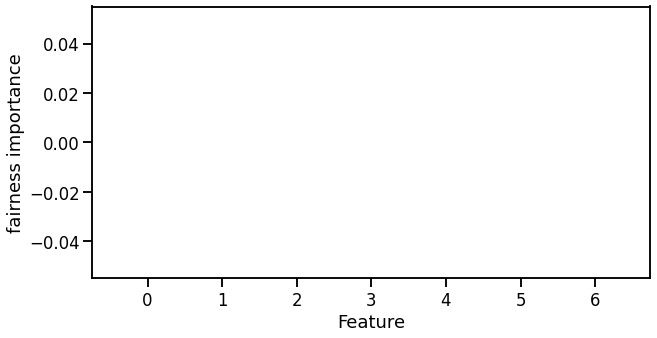

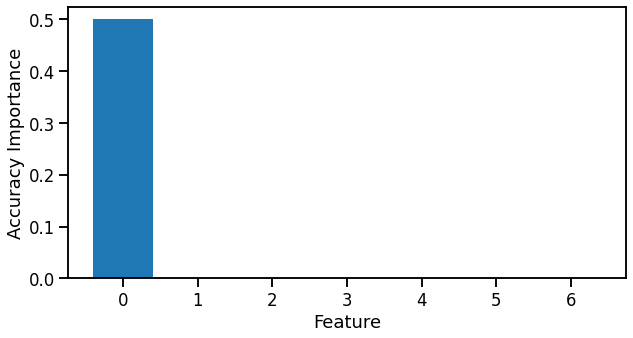

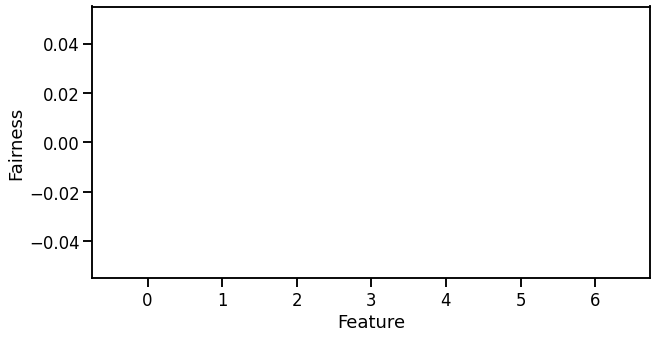

In [19]:
for i in range (7):
    score_fairness[i] /= 10
    score_feature[i] /= 10
    occlusion_fairness[i] /= 10
with open('Results/Synthetic/result_eqop.txt', 'a') as f:
    f.writelines(str(score_fairness))
    f.writelines("\n")
    f.writelines(str(score_feature))
    f.writelines("\n")
    f.writelines(str(occlusion_fairness))

utils.draw_plot(feature,score_fairness,"Results/Synthetic/eqop_fairness.pdf", "fairness importance")
utils.draw_plot(feature,score_feature,"Results/Synthetic/eqop_feature.pdf","Accuracy Importance")
utils.draw_plot(feature,occlusion_fairness,"Results/Synthetic/no_corr/eqop_fairness_occlusion.pdf","Fairness")